In [106]:
from __future__ import absolute_import, division, print_function, unicode_literals
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [107]:
df = pd.read_csv('무Model.csv')
df.head()

,날짜,평균강수량,최대강수량,평균기온,최고기온,최저기온,평균습도,최저습도,평균풍속,최대풍속,...,자동차용경유,소비자물가지수,농축수산물,공업제품,집세,공공서비스,개인서비스,근원물가,생활물가,무가격
0,2014-01-03,0.0,0.0,2.6,10.1,-3.2,54,12,1.2,9.6,...,1707.15,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,307.198836
1,2014-01-04,1.2,31.0,1.5,6.9,-2.8,63,12,1.7,11.9,...,1707.61,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,300.931167
2,2014-01-06,0.0,11.0,0.2,7.6,-5.1,59,12,1.1,7.7,...,1707.80,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,264.600638
3,2014-01-07,0.0,1.5,1.9,7.8,-4.3,60,16,1.1,8.0,...,1707.73,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,250.029575
4,2014-01-08,1.8,41.3,2.1,5.3,-1.4,65,25,2.4,17.7,...,1707.70,1.1,-5.6,1.7,2.4,0.7,1.2,1.7,0.6,249.798757


In [108]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [117]:
TRAIN_SPLIT = int(len(df)*0.7)
# 재현성을 보장하기 위해 시드 설정.
tf.random.set_seed(13)

In [110]:
uni_data = df['무가격']
uni_data.index = df['날짜']
uni_data.head()

날짜
2014-01-03    307.198836
2014-01-04    300.931167
2014-01-06    264.600638
2014-01-07    250.029575
2014-01-08    249.798757
Name: 무가격, dtype: float64

array([<AxesSubplot:xlabel='날짜'>], dtype=object)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 45216 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 51676 missing from current font.
  font.set_text(s, 0, flags=flags)


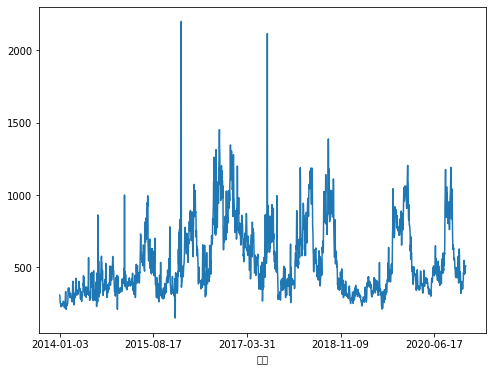

In [111]:
uni_data.plot(subplots=True)

In [112]:
uni_data = uni_data.values

In [118]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
# 데이터를 표준화합시다.
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [119]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [120]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.00295183]
 [-1.02828505]
 [-1.17512898]
 [-1.23402359]
 [-1.23495653]
 [-1.23141202]
 [-1.23941326]
 [-1.32823219]
 [-1.28583725]
 [-1.30466705]
 [-1.27008874]
 [-1.26025549]
 [-1.28665488]
 [-1.30529214]
 [-1.24515151]
 [-1.24601153]
 [-1.23541068]
 [-1.22935812]
 [-1.19295222]
 [-1.17401892]]

 Target temperature to predict
-1.1811849634013478


In [121]:
def create_time_steps(length):
  return list(range(-length, 0))

In [122]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

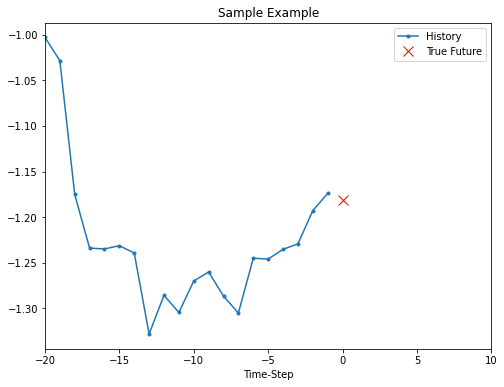

In [123]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

<module 'matplotlib.pyplot' from 'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\matplotlib\\pyplot.py'>

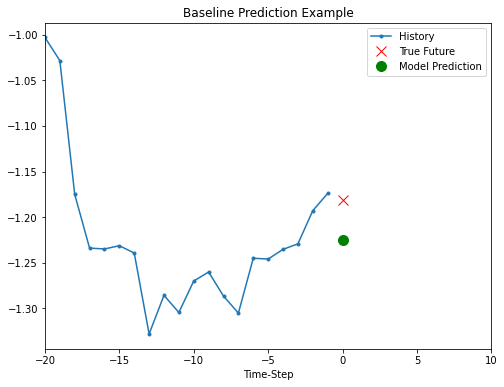

In [124]:
def baseline(history):
  return np.mean(history)

show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

In [182]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [183]:
simple_lstm_model = tf.keras.models.Sequential([
      # x_train_uni.shape = (299980, 20, 1)
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [184]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


In [185]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 3s 7ms/step - loss: 0.4465 - val_loss: 0.2372
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2851 - val_loss: 0.1744
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.2552 - val_loss: 0.1556
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2390 - val_loss: 0.1453
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2288 - val_loss: 0.1395
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2242 - val_loss: 0.1376
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2224 - val_loss: 0.1374
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2211 - val_loss: 0.1370
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2208 - val_loss: 0.1367
Epoch 10/10
200/200 [==============================] - 1s 6ms/step - loss: 0.2199 - val_loss: 0.1365

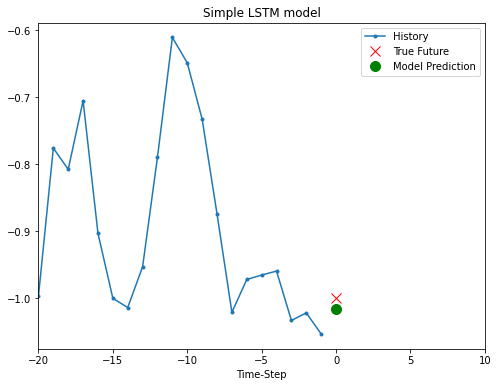

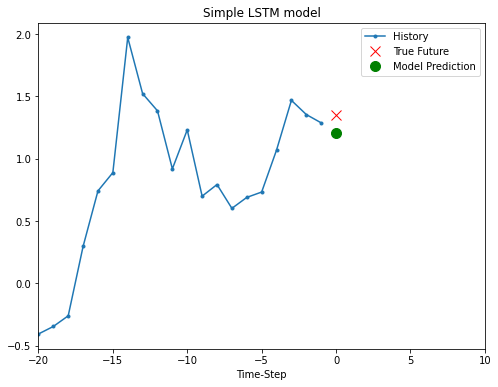

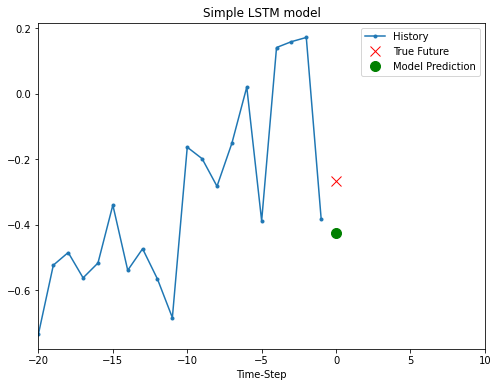

In [186]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

In [247]:
features = df.iloc[:,[1,3,6,8,10,15,16,17,18,19,20,27]]
features.index = df['날짜']
features.head()

,평균강수량,평균기온,평균습도,평균풍속,무거래량,무재배면적,고급휘발유,보통휘발유,자동차용경유,소비자물가지수,농축수산물,무가격
날짜,,,,,,,,,,,,
2014-01-03,0.0,2.6,54,1.2,833.98,21030,2200.04,1888.51,1707.15,1.1,-5.6,307.198836
2014-01-04,1.2,1.5,63,1.7,615.89,21030,2199.92,1888.98,1707.61,1.1,-5.6,300.931167
2014-01-06,0.0,0.2,59,1.1,870.91,21030,2200.38,1889.14,1707.80,1.1,-5.6,264.600638
2014-01-07,0.0,1.9,60,1.1,818.27,21030,2200.69,1889.15,1707.73,1.1,-5.6,250.029575
2014-01-08,1.8,2.1,65,2.4,599.28,21030,2200.98,1889.16,1707.70,1.1,-5.6,249.798757


array([<AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>,
       <AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>,
       <AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>,
       <AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>,
       <AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>,
       <AxesSubplot:xlabel='날짜'>, <AxesSubplot:xlabel='날짜'>], dtype=object)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54217 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 47049 missing from current font.
  font.set_text(s, 0.0

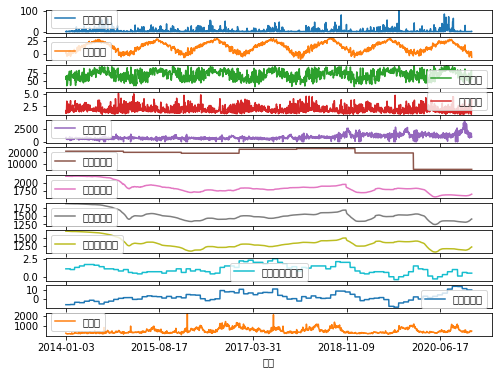

In [248]:
features.plot(subplots=True)

In [249]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
# 표준화
dataset = (dataset-data_mean)/data_std

In [250]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In [252]:
past_history = 500
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

print ('Single window of past history : {}'.format(x_train_single[0].shape))                                        

Single window of past history : (500, 12)


In [253]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()


In [254]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [255]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(150, 1)


In [256]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 87s 426ms/step - loss: 0.2126 - val_loss: 0.5734
Epoch 2/10
200/200 [==============================] - 86s 429ms/step - loss: 0.1595 - val_loss: 0.6118
Epoch 3/10
200/200 [==============================] - 86s 428ms/step - loss: 0.1426 - val_loss: 0.6257
Epoch 4/10
200/200 [==============================] - 86s 429ms/step - loss: 0.1298 - val_loss: 0.6282
Epoch 5/10
200/200 [==============================] - 86s 432ms/step - loss: 0.1193 - val_loss: 0.6229
Epoch 6/10
200/200 [==============================] - 86s 431ms/step - loss: 0.1110 - val_loss: 0.6233
Epoch 7/10
200/200 [==============================] - 86s 432ms/step - loss: 0.1042 - val_loss: 0.6493
Epoch 8/10
200/200 [==============================] - 87s 436ms/step - loss: 0.0980 - val_loss: 0.6996
Epoch 9/10
200/200 [==============================] - 87s 436ms/step - loss: 0.0925 - val_loss: 0.7277
Epoch 10/10
200/200 [==============================] - 87s 436ms/step - l

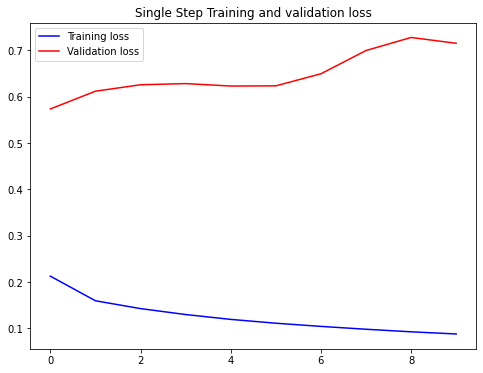

In [257]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

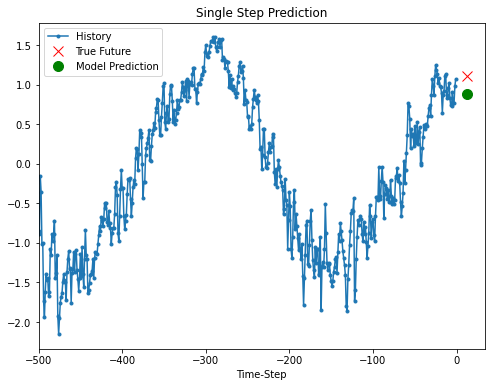

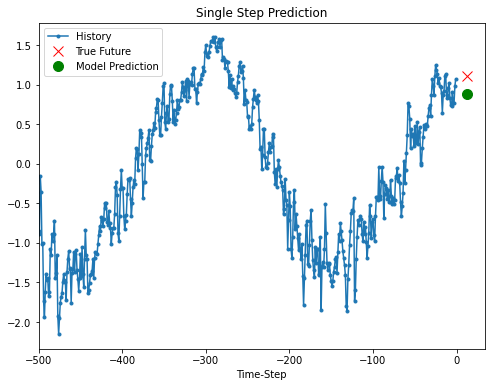

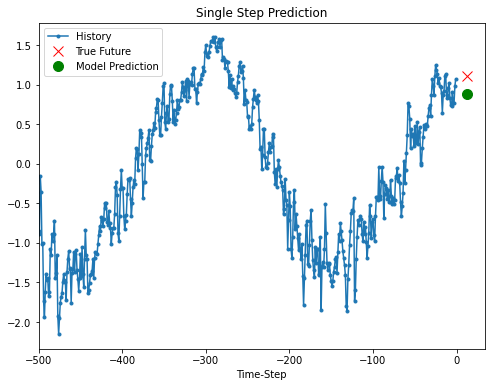

In [258]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
  plot.show()

In [266]:
future_target = 100
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))                                            

Single window of past history : (500, 12)

 Target temperature to predict : (100,)


In [267]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

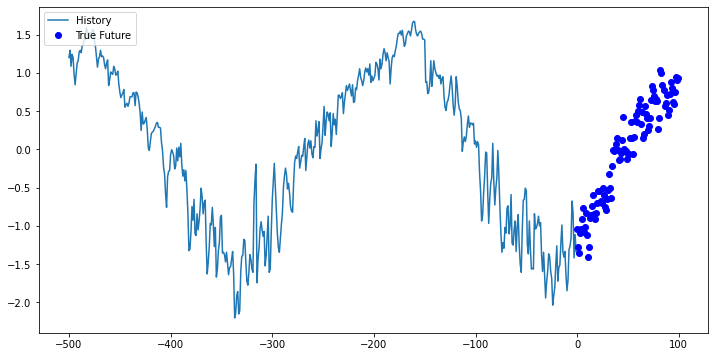

In [268]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))  

In [273]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [274]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(51, 1)


In [275]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 158s 774ms/step - loss: nan - val_loss: nan
Epoch 2/10
200/200 [==============================] - 158s 788ms/step - loss: nan - val_loss: nan
Epoch 3/10
200/200 [==============================] - 156s 780ms/step - loss: nan - val_loss: nan
Epoch 4/10
200/200 [==============================] - 154s 772ms/step - loss: nan - val_loss: nan
Epoch 5/10
200/200 [==============================] - 158s 788ms/step - loss: nan - val_loss: nan
Epoch 6/10
200/200 [==============================] - 160s 800ms/step - loss: nan - val_loss: nan
Epoch 7/10
200/200 [==============================] - 158s 788ms/step - loss: nan - val_loss: nan
Epoch 8/10
200/200 [==============================] - 156s 782ms/step - loss: nan - val_loss: nan
Epoch 9/10
200/200 [==============================] - 156s 781ms/step - loss: nan - val_loss: nan
Epoch 10/10
200/200 [==============================] - 159s 797ms/step - loss: nan - val_loss: nan


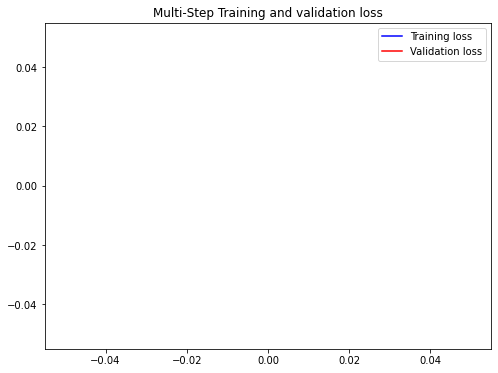

In [276]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

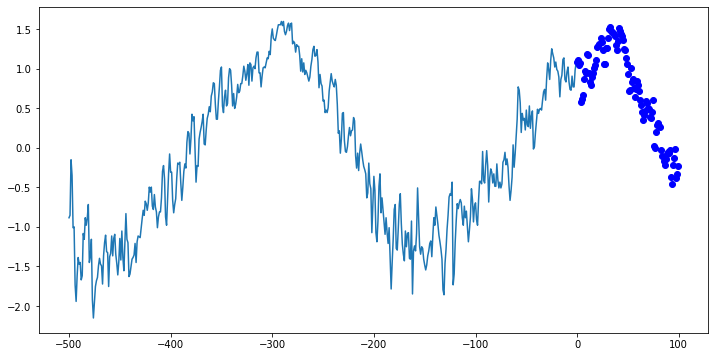

In [278]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])